In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | Happy with the flight crew. Ha...
1,✅ Trip Verified | Horrible service from boar...
2,Not Verified | My wife and I are very disappo...
3,Not Verified | We flew BA between Heathrow an...
4,Not Verified | Absolutely disgusted with BA. ...


In [ ]:
df.to_csv("BA_reviews.csv")


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure you have necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_review(review):
    # Remove punctuation and numbers
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    # Convert to lowercase
    review = review.lower()
    # Tokenize and remove stopwords
    tokens = review.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_reviews'] = df['reviews'].apply(clean_review)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['cleaned_reviews'].head()

,cleaned_reviews
0,verified happy flight crew hadnt plane year st...
1,trip verified horrible service boarding landin...
2,verified wife disappointed flying british airw...
3,verified flew ba heathrow berlin one way conne...
4,verified absolutely disgusted ba flight cancel...


In [ ]:
from textblob import TextBlob

# Function to get sentiment polarity and classify it into categories
def classify_sentiment(review):
    analysis = TextBlob(review)
    polarity = analysis.sentiment.polarity

    if polarity < 0:
        return "negative"
    elif polarity==0:
        return "neutral"
    else:
        return "positive"

# Apply the function to the cleaned reviews
df['sentiment_category'] = df['cleaned_reviews'].apply(classify_sentiment)

# Display a few examples
df[['reviews', 'cleaned_reviews', 'sentiment_category']].head()


,reviews,cleaned_reviews,sentiment_category
0,Not Verified | Happy with the flight crew. Ha...,verified happy flight crew hadnt plane year st...,positive
1,✅ Trip Verified | Horrible service from boar...,trip verified horrible service boarding landin...,negative
2,Not Verified | My wife and I are very disappo...,verified wife disappointed flying british airw...,negative
3,Not Verified | We flew BA between Heathrow an...,verified flew ba heathrow berlin one way conne...,positive
4,Not Verified | Absolutely disgusted with BA. ...,verified absolutely disgusted ba flight cancel...,negative


In [ ]:
df.drop('reviews', axis=1, inplace=True)
df.rename(columns={'cleaned_reviews': 'reviews'}, inplace=True)

In [ ]:
df.head()

,reviews,cleaned_reviews,sentiment_category
0,Not Verified | Happy with the flight crew. Ha...,verified happy flight crew hadnt plane year st...,positive
1,✅ Trip Verified | Horrible service from boar...,trip verified horrible service boarding landin...,negative
2,Not Verified | My wife and I are very disappo...,verified wife disappointed flying british airw...,negative
3,Not Verified | We flew BA between Heathrow an...,verified flew ba heathrow berlin one way conne...,positive
4,Not Verified | Absolutely disgusted with BA. ...,verified absolutely disgusted ba flight cancel...,negative


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert text data to a matrix of token counts
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = count_vectorizer.fit_transform(df['reviews'])

# Create LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Display the top words in each topic
for index, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{index}:")
    print([count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("\n")


Top 10 words for topic #0:
['good', 'trip', 'time', 'food', 'ba', 'service', 'class', 'business', 'flight', 'seat']


Top 10 words for topic #1:
['london', 'service', 'airline', 'customer', 'trip', 'airway', 'british', 'hour', 'ba', 'flight']


Top 10 words for topic #2:
['airport', 'voucher', 'london', 'hour', 'time', 'trip', 'day', 'cancelled', 'ba', 'flight']


Top 10 words for topic #3:
['passenger', 'time', 'airline', 'cabin', 'trip', 'service', 'seat', 'staff', 'flight', 'ba']


Top 10 words for topic #4:
['cabin', 'time', 'food', 'service', 'good', 'crew', 'trip', 'seat', 'ba', 'flight']




In [ ]:
df['sentiment_category'].value_counts()

,count
sentiment_category,
positive,619
negative,365
neutral,16


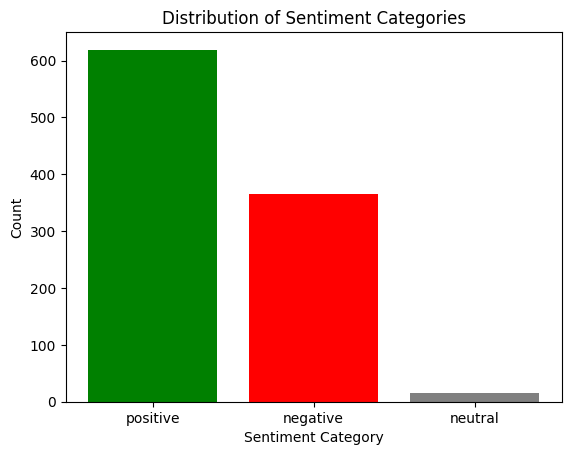

In [ ]:
import matplotlib.pyplot as plt
colour = ['green','red','gray']
plt.bar(df['sentiment_category'].value_counts().index, df['sentiment_category'].value_counts().values,color=colour)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Categories')
plt.show()


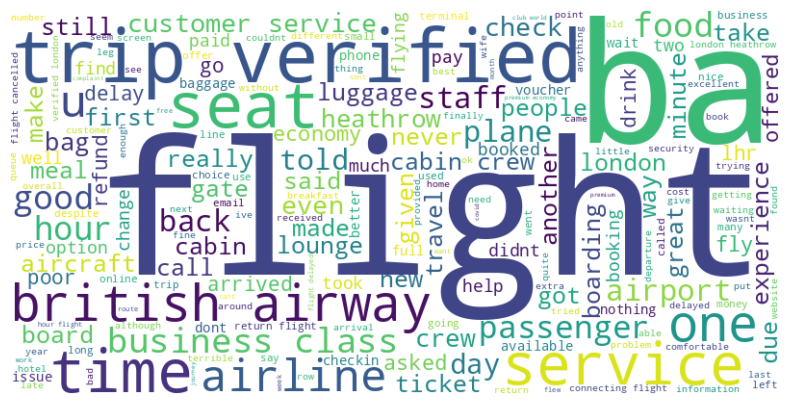

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the reviews into one text
text = ' '.join(review for review in df['reviews'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
